<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Downtown_LA_Traffic_Prediction_US101_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [ ]:
controller_data = pd.read_csv('Combined flows US101.csv')
controller_data.dropna(how='all', inplace=True)

In [ ]:
controller_data["5 Minutes"] = pd.to_datetime(controller_data["5 Minutes"])
controller_data.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow = controller_data[['RAMPART Flow (Veh/5 Minutes)', 'ALVARADO Flow (Veh/5 Minutes)', 'GLENDALE Flow (Veh/5 Minutes)', 'EDGEWARE Flow (Veh/5 Minutes)', 'N OF 110 Flow (Veh/5 Minutes)', 'BROADWAY Flow (Veh/5 Minutes)', 'FIRST STREET Flow (Veh/5 Minutes)', 'LOS ANGELES ST Flow (Veh/5 Minutes)', 'GAREY STREET Flow (Veh/5 Minutes)', 'CONCORD Flow (Veh/5 Minutes)', 'CALZONA Flow (Veh/5 Minutes)', 'DITMAN Flow (Veh/5 Minutes)']]

print(time_flow)

                     RAMPART Flow (Veh/5 Minutes)  \
5 Minutes                                           
2024-04-01 00:00:00                         186.0   
2024-04-01 00:05:00                         182.0   
2024-04-01 00:10:00                         175.0   
2024-04-01 00:15:00                         172.0   
2024-04-01 00:20:00                         168.0   
...                                           ...   
2024-04-07 23:35:00                         228.0   
2024-04-07 23:40:00                         221.0   
2024-04-07 23:45:00                         214.0   
2024-04-07 23:50:00                         206.0   
2024-04-07 23:55:00                         193.0   

                     ALVARADO Flow (Veh/5 Minutes)  \
5 Minutes                                            
2024-04-01 00:00:00                          186.0   
2024-04-01 00:05:00                          182.0   
2024-04-01 00:10:00                          175.0   
2024-04-01 00:15:00                     

In [ ]:
print(time_flow.shape)

(2016, 12)


In [ ]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [ ]:
# Train and validation split
train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train), :], flow_normalised[int(train):, :]

In [ ]:
print(X_train.shape)

(1612, 12)


In [ ]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)


# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

In [ ]:
print(X_train.shape)

(1600, 12, 12)


In [ ]:
from keras import layers

input_layer = keras.layers.Input(shape=(look_back, 12))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(1, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 12, 12)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 12, 64)              │          19,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 12, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 12, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,025 (222.75 KB)

 Trainable params: 57,025 (222.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.2666 - val_loss: 0.0320
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0260 - val_loss: 0.0093
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0096 - val_loss: 0.0080
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0086 - val_loss: 0.0073
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0081 - val_loss: 0.0070
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0

In [ ]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [ ]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(1, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7822 - val_loss: 0.4193
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4144 - val_loss: 0.3700
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3541 - val_loss: 0.0365
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - val_loss: 0.0113
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0160 - val_loss: 0.0109
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - val_loss: 0.0106
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133 - val_loss: 0.0101
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0101
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0123 - val_loss: 0.0096
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0094
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0116 - val_loss: 0.0093
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0091


In [ ]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


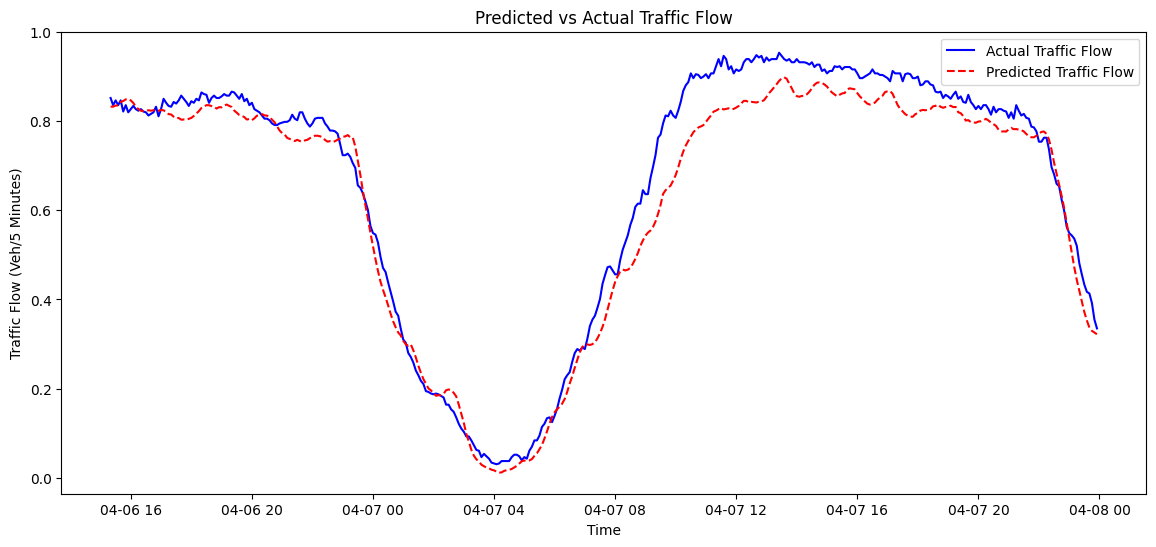

In [ ]:
# timestamps from validation set.
timestamps = time_flow.index[-len(y_val):]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_val[:, -1], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps, y_pred, label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/5 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.show()


In [ ]:
from folium.plugins import HeatMapWithTime
import folium
import pandas as pd
import numpy as np
import branca.colormap as cm

# Sample time_flow DataFrame
# Ensure that your actual DataFrame has a timestamp index and valid flow data
time_flow = pd.DataFrame({
    "RAMPART": time_flow['RAMPART Flow (Veh/5 Minutes)'].tolist(),
    "ALVARADO": time_flow['ALVARADO Flow (Veh/5 Minutes)'].tolist(),
    "GLENDALE": time_flow['GLENDALE Flow (Veh/5 Minutes)'].tolist(),
    "EDGEWARE": time_flow['EDGEWARE Flow (Veh/5 Minutes)'].tolist(),
    "N_OF_110": time_flow['N OF 110 Flow (Veh/5 Minutes)'].tolist(),
    "BROADWAY": time_flow['BROADWAY Flow (Veh/5 Minutes)'].tolist(),
    "FIRST_STREET": time_flow['FIRST STREET Flow (Veh/5 Minutes)'].tolist(),
    "LOS_ANGELES_ST": time_flow['LOS ANGELES ST Flow (Veh/5 Minutes)'].tolist(),
    "GAREY_STREET": time_flow['GAREY STREET Flow (Veh/5 Minutes)'].tolist(),
    "CONCORD": time_flow['CONCORD Flow (Veh/5 Minutes)'].tolist(),
    "CALZONA": time_flow['CALZONA Flow (Veh/5 Minutes)'].tolist(),
    "DITMAN": time_flow['DITMAN Flow (Veh/5 Minutes)'].tolist()
}, index=pd.date_range("2024-04-01", periods=2016, freq="5T"))

detector_locations = {
    "RAMPART": (34.074797, -118.273463),
    "ALVARADO": (34.071462, -118.265891),
    "GLENDALE": (34.070002, -118.262279),
    "EDGEWARE": (34.067067, -118.254688),
    "N_OF_110": (34.064756, -118.251325),
    "BROADWAY": (34.056861, -118.242427),
    "FIRST_STREET": (34.056156, -118.241309),
    "LOS_ANGELES_ST": (34.053705, -118.235846),
    "GAREY_STREET": (34.053512, -118.232514),
    "CONCORD": (34.025109, -118.20517),
    "CALZONA": (34.020961, -118.195456),
    "DITMAN": (34.020088, -118.189029)
}

# Normalize flow values
max_flow = time_flow.max().max()
time_flow = time_flow / max_flow  # Scale between 0-1

# Prepare Heatmap Data
heatmap_data = []
for timestamp, row in time_flow.iterrows():
    time_slot = []
    for column, flow_value in row.items():
        detector_id = column.split()[0]
        if detector_id in detector_locations:
            lat, lon = detector_locations[detector_id]
            time_slot.append([lat, lon, flow_value])
    heatmap_data.append(time_slot)

# Flatten the data
flattened_data = []
for timestamp, time_slot in zip(time_flow.index, heatmap_data):
    for lat, lon, weight in time_slot:
        flattened_data.append([timestamp, lat, lon, weight])

# Create DataFrame
df_heatmap = pd.DataFrame(flattened_data, columns=["Timestamp", "Latitude", "Longitude", "Weight"])

# Convert Timestamp to datetime and sort
df_heatmap['Timestamp'] = pd.to_datetime(df_heatmap['Timestamp'])
df_heatmap = df_heatmap.sort_values(by="Timestamp")

# Prepare data for HeatMapWithTime
time_index = list(df_heatmap['Timestamp'].astype(str).unique())

data = []
for _, d in df_heatmap.groupby('Timestamp'):
    data.append([[row['Latitude'], row['Longitude'], row['Weight']] for _, row in d.iterrows()])

hmt = folium.Map(location=[34.056156, -118.241309],
                tiles="cartodbpositron",
                zoom_start=13,
                control_scale=True,
                max_zoom=12,
                min_zoom=13
                 )

HeatMapWithTime(data,
                index=time_index,
                auto_play=True,
                max_opacity=0.8,
                radius=15,
                use_local_extrema=False
               ).add_to(hmt)

hmt


<ipython-input-20-da7f057d1125>:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  }, index=pd.date_range("2024-04-01", periods=2016, freq="5T"))
